<h1>Brais Míguez Varela</h1>


## Variables globales y importaciones


In [8]:
# -------------------- Standard Library --------------------
import hashlib
import json
import os
import time
from typing import Any, List, Tuple

# -------------------- Additional Libraries --------------------
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import torch
from dateutil import parser
from psycopg2 import sql
import psycopg2

# -------------------- Machine Learning - scikit-learn --------------------
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    hamming_loss,
    jaccard_score,
)
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.svm import LinearSVC

# -------------------- Cross-Validation --------------------
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

# -------------------- NLP & Transformers --------------------
import nlpaug.augmenter.word as naw
from transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
)
from torch.utils.data import Dataset

from transformers.utils import logging

logging.set_verbosity_error()

import warnings

warnings.filterwarnings("ignore", category=UserWarning)

class TareaDataset(Dataset):
    """Dataset para las tareas de clasificación.

    Args:
        Dataset (torch.utils.data.Dataset): Dataset personalizado para tareas de clasificación multilabel.
    Attributes:
        encodings (dict): Diccionario con las codificaciones de los textos.
        labels (list): Lista de etiquetas correspondientes a cada texto.

    Description:
        Clase que hereda de torch.utils.data.Dataset para manejar las tareas de clasificación multilabel.
        Utiliza un tokenizador BERT para codificar los textos y almacena las etiquetas correspondientes.
    """
    
    def __init__(self, textos, etiquetas, tokenizer):
        """Inicializa el dataset con textos y etiquetas.
        Args:
            textos (list): Lista de textos a codificar.
            etiquetas (list): Lista de etiquetas correspondientes a los textos.
            tokenizer (BertTokenizer): Tokenizador BERT para codificar los textos.
        """
        self.encodings = tokenizer(
            textos, truncation=True, padding=True, max_length=256
        ) # Codificamos los textos con el tokenizador BERT, truncando y rellenando a un máximo de 256 tokens
        self.labels = etiquetas # Almacenamos las etiquetas correspondientes a los textos

    def __len__(self):
        """Devuelve el número de etiquetas."""
        return len(self.labels)

    def __getitem__(self, idx):
        """Obtiene un ítem del dataset por índice.
        Args:
            idx (int): Índice del ítem a obtener.
        Returns:
            item (dict): Diccionario con las codificaciones y etiquetas del ítem.
        """
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx]).float()
        return item

## Análisis de los datos


In [2]:
# Configuración de conexión
db_config: dict[str, str | int] = {
    "dbname": "Jira",
    "user": "test",
    "password": "test",
    "host": "postgres",
    "port": 5432,
}

# Consulta a la base de datos
query: str = "SELECT * FROM tareas"
query_empleados: str = "SELECT codificacion, habilidades FROM empleados"


# Leer los datos directamente a un DataFrame
with psycopg2.connect(**db_config) as conn:
    tasks_dat: pd.DataFrame = pd.read_sql_query(query, conn)
    empleados_dat: pd.DataFrame = pd.read_sql_query(query_empleados, conn)


display(tasks_dat)

,id,clave,fecha,timespent_real,timespent_estimado,bien_estimado,project_key,assignee,status_text,issue_type,texto,mejores_empleados,habilidades_extraidas,fecha_modificacion
0,1634,4f0d53b8da47e393a8d6550d21e20bd4d1885dba533231...,2025-04-30 15:03:31,0.0,0.000000,True,4f0d53b8da47e393a8d6550d21e20bd4d1885dba533231...,ac52e2f0efacf6d040632f98d3dcde4883525efaa23e89...,To Do,Sub-task,Insertar en SR_PRESTACIONES la informacion de ...,None,None,2025-05-27
1,1704,4f0d53b8da47e393a8d6550d21e20bd4d1885dba533231...,2025-04-02 15:52:48,0.0,13482.620690,True,4f0d53b8da47e393a8d6550d21e20bd4d1885dba533231...,df594d8325b31e7527db82d3743eb41d87003044fb948f...,Resolved,Task,PE 1434822 [ELESEG] Seguimiento e incidencias ...,None,None,2025-05-27
2,1795,4f0d53b8da47e393a8d6550d21e20bd4d1885dba533231...,2024-12-19 17:34:04,10800.0,32819.512195,True,4f0d53b8da47e393a8d6550d21e20bd4d1885dba533231...,ac52e2f0efacf6d040632f98d3dcde4883525efaa23e89...,Resolved,Sub-task,MEP TWS PRUEBAS\n,None,None,2025-05-27
3,1813,4f0d53b8da47e393a8d6550d21e20bd4d1885dba533231...,2024-12-02 11:22:24,7200.0,20625.184358,True,4f0d53b8da47e393a8d6550d21e20bd4d1885dba533231...,None,Closed,Sub-task,IN1229483 [ALM][DTPCAT] Error al desplegar com...,None,None,2025-05-27
4,1820,4f0d53b8da47e393a8d6550d21e20bd4d1885dba533231...,2025-03-11 13:54:47,14400.0,32819.512195,True,4f0d53b8da47e393a8d6550d21e20bd4d1885dba533231...,ac52e2f0efacf6d040632f98d3dcde4883525efaa23e89...,Resolved,Sub-task,IOP 20241112 SG_TX_PRIMAS_SCA_PH para PLY\nFA...,None,None,2025-05-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7493,6318,0a407d52f2a4a40ddf6b63cb8df3ec616c3059dcc3675c...,2024-10-15 11:37:13,0.0,0.000000,True,0a407d52f2a4a40ddf6b63cb8df3ec616c3059dcc3675c...,None,To Do,Sub-task,Peticion SAI 1383325 [ELEMBK]No se puede selec...,None,None,2025-05-27
7494,6339,0a407d52f2a4a40ddf6b63cb8df3ec616c3059dcc3675c...,2024-09-24 09:06:31,10800.0,32914.285714,True,0a407d52f2a4a40ddf6b63cb8df3ec616c3059dcc3675c...,9db25dda2358663c54d29d91c51bc4650756eeb6171475...,Resolved,Sub-task,Id Impacto BDM: 9342 ELECLI\n,None,None,2025-05-27
7495,6357,0a407d52f2a4a40ddf6b63cb8df3ec616c3059dcc3675c...,2024-09-02 16:01:40,0.0,0.000000,True,0a407d52f2a4a40ddf6b63cb8df3ec616c3059dcc3675c...,None,To Do,Sub-task,Id Impacto BDM: 8022 ELECLI\n,None,None,2025-05-27
7496,6705,0a407d52f2a4a40ddf6b63cb8df3ec616c3059dcc3675c...,2023-08-09 14:38:48,0.0,0.000000,True,0a407d52f2a4a40ddf6b63cb8df3ec616c3059dcc3675c...,None,To Do,Task,PE 1240521 [ELEMBK] - Seguimiento e incidencia...,None,None,2025-05-27


### Modelo 1 - Habilidades


Lo primero que se va a hacer es etiquetar a mano unas 20 tareas para que otros modelos puedan sacar las habilidades que se necesitan para poder clasificar. Las posibles habilidades que se me ocurren son:

- ODI
- SQL
- IN
- RTC
- Reclamacion por SR
- Desarrollo general
- Reclamacion por correo


In [3]:
tareas_etiquetadas: pd.DataFrame = pd.read_csv("data/tareas_preetiquetadas.csv")

tareas_etiquetadas["habilidades"] = tareas_etiquetadas["habilidades"].str.split("|")

display(tareas_etiquetadas)

,clave,habilidades
0,e385135a7301db0cd2b2b730ca8f9c53b261eeee50c848...,"[ODI, SQL, IN, reclamaciones_correo]"
1,e385135a7301db0cd2b2b730ca8f9c53b261eeee50c848...,"[RTC, SQL, Desarrollo]"
2,e385135a7301db0cd2b2b730ca8f9c53b261eeee50c848...,"[RTC, SQL, Desarrollo]"
3,e385135a7301db0cd2b2b730ca8f9c53b261eeee50c848...,"[RTC, SQL, Desarrollo]"
4,4f0d53b8da47e393a8d6550d21e20bd4d1885dba533231...,[Desarrollo]
5,a11c6ca0dcca2896321aad9dfc81639dc35f5ef50b783d...,"[IN, ODI]"
6,a11c6ca0dcca2896321aad9dfc81639dc35f5ef50b783d...,[reclamaciones_correo]
7,a11c6ca0dcca2896321aad9dfc81639dc35f5ef50b783d...,[SQL]
8,a11c6ca0dcca2896321aad9dfc81639dc35f5ef50b783d...,[SR]
9,a11c6ca0dcca2896321aad9dfc81639dc35f5ef50b783d...,[RTC]


#### Modelo 1 - Entrenamiento


In [4]:
# ------------------------------------------
# ----- Generar dataset de entrenamiento ---
# ------------------------------------------

claves: list[str] = tareas_etiquetadas["clave"].unique().tolist()

# Armar consulta SQL
consulta: str = f"""
SELECT clave, texto
FROM tareas
WHERE clave IN %(claves)s
"""

with psycopg2.connect(**db_config) as conn:
    tareas_texto: pd.DataFrame = pd.read_sql_query(consulta, conn, params={"claves": tuple(claves)})


# Unir etiquetas y texto
tareas_etiquetadas_texto: pd.DataFrame = tareas_etiquetadas.merge(tareas_texto, on="clave", how="inner")

Al disponer de pocos datos, se van a usar técnicas de data augmentation para generar más datos. Se van a usar las siguientes técnicas:
- Sinónimos: se van a sustituir palabras por sinónimos.
- Palabras aleatorias: se van a sustituir palabras por palabras aleatorias.
- Palabras aleatorias con sinónimos: se van a sustituir palabras por palabras aleatorias y sinónimos.

In [5]:
# ------------------------------------------
# ------------ Aumentar Tareas -------------
# ------------------------------------------

aug: naw.ContextualWordEmbsAug = naw.ContextualWordEmbsAug(
    model_path="./modelos/", action="substitute", model_type="bert"
) # Cargamos el modelo desde local

tareas_aug: list[dict] = [] # Lista para almacenar las tareas aumentadas

for i, row in tareas_etiquetadas_texto.iterrows(): # Iteramos sobre cada fila de las tareas etiquetadas con texto

    texto: str = row["texto"] # Obtenemos el texto de la tarea
    habilidades: list[str] = row["habilidades"] # Obtenemos las habilidades de la tarea
    clave: str = row["clave"] # Obtenemos la clave de la tarea

    print(f"Aumentando tarea: {i+1}")

    resultados = aug.augment(texto, n=3) # Aumentamos el texto de la tarea 3 veces
    
    for i, t in enumerate(resultados): # Iteramos sobre los resultados de aumento de texto
        tareas_aug.append(
            {
                "clave_tarea": f"{clave}_aug{i}",
                "description": t,
                "habilidades": habilidades,
            }
        ) # Agregamos cada tarea aumentada a la lista con su clave, descripción y habilidades


# Crear DataFrame de aumentos
df_aug: pd.DataFrame = pd.DataFrame(tareas_aug)

# Concatenar DataFrames originales y aumentados
df: pd.DataFrame = pd.concat([tareas_etiquetadas_texto, df_aug], ignore_index=True)

# Convertir habilidades a listas
df["habilidades"] = df["habilidades"].apply(
    lambda x: x.split("|") if isinstance(x, str) else x
)

Aumentando tarea: 1
Aumentando tarea: 2
Aumentando tarea: 3
Aumentando tarea: 4
Aumentando tarea: 5
Aumentando tarea: 6
Aumentando tarea: 7
Aumentando tarea: 8
Aumentando tarea: 9
Aumentando tarea: 10
Aumentando tarea: 11
Aumentando tarea: 12
Aumentando tarea: 13
Aumentando tarea: 14
Aumentando tarea: 15
Aumentando tarea: 16
Aumentando tarea: 17
Aumentando tarea: 18
Aumentando tarea: 19
Aumentando tarea: 20
Aumentando tarea: 21
Aumentando tarea: 22
Aumentando tarea: 23
Aumentando tarea: 24
Aumentando tarea: 25


Entrenando modelo: LogisticRegression
Entrenando modelo: RandomForest
Entrenando modelo: MultinomialNB
Entrenando modelo: LinearSVC
Entrenando modelo: BERT (con cross-validation)


/tmp/ipykernel_84/2260640844.py:95: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 0.6488, 'grad_norm': 3.0096676349639893, 'learning_rate': 3.928571428571429e-05, 'epoch': 0.7142857142857143}
{'loss': 0.6327, 'grad_norm': 3.4941611289978027, 'learning_rate': 2.7380952380952383e-05, 'epoch': 1.4285714285714286}
{'loss': 0.5883, 'grad_norm': 2.327069044113159, 'learning_rate': 1.5476190476190476e-05, 'epoch': 2.142857142857143}
{'loss': 0.5978, 'grad_norm': 2.8095028400421143, 'learning_rate': 3.5714285714285714e-06, 'epoch': 2.857142857142857}
{'train_runtime': 530.9142, 'train_samples_per_second': 0.299, 'train_steps_per_second': 0.079, 'train_loss': 0.6116769313812256, 'epoch': 3.0}


/tmp/ipykernel_84/2260640844.py:95: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


{'loss': 0.6647, 'grad_norm': 2.6795542240142822, 'learning_rate': 3.7500000000000003e-05, 'epoch': 0.8333333333333334}
{'loss': 0.6187, 'grad_norm': 1.8720874786376953, 'learning_rate': 2.361111111111111e-05, 'epoch': 1.6666666666666665}
{'loss': 0.622, 'grad_norm': 2.0734336376190186, 'learning_rate': 9.722222222222223e-06, 'epoch': 2.5}
{'train_runtime': 447.7828, 'train_samples_per_second': 0.315, 'train_steps_per_second': 0.08, 'train_loss': 0.6321779820654128, 'epoch': 3.0}


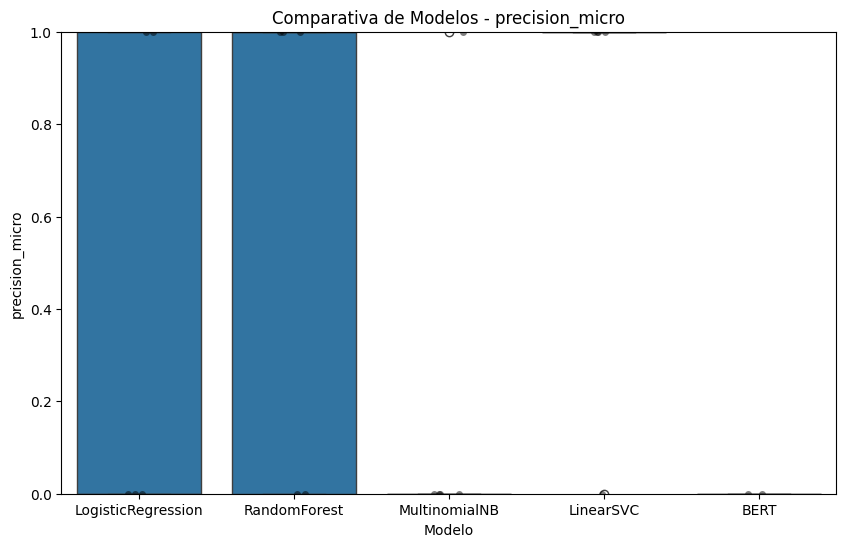

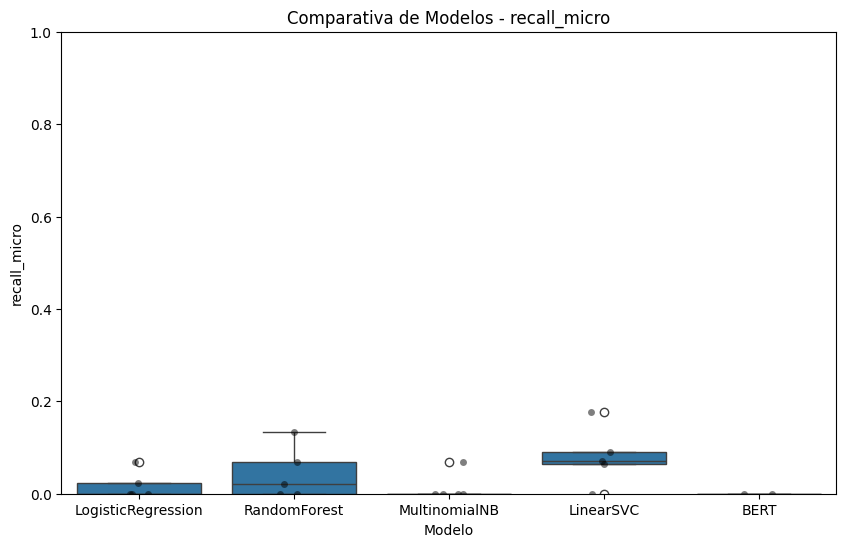

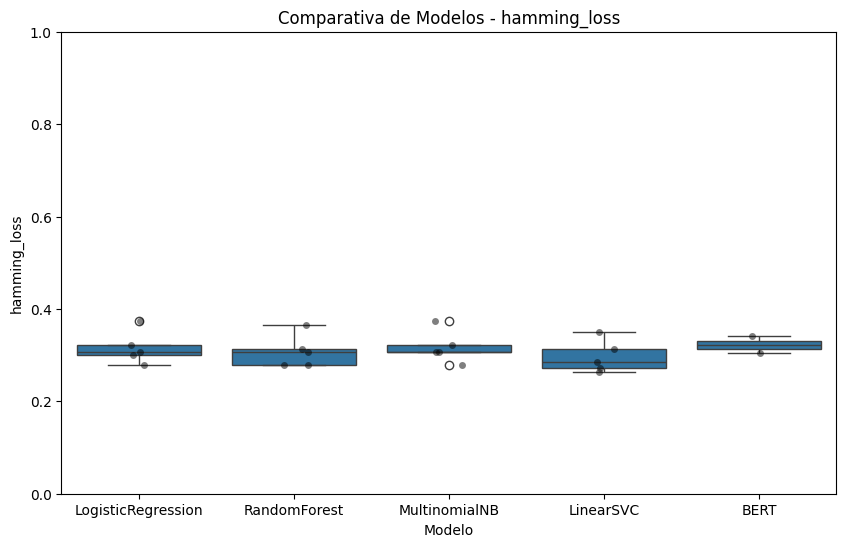

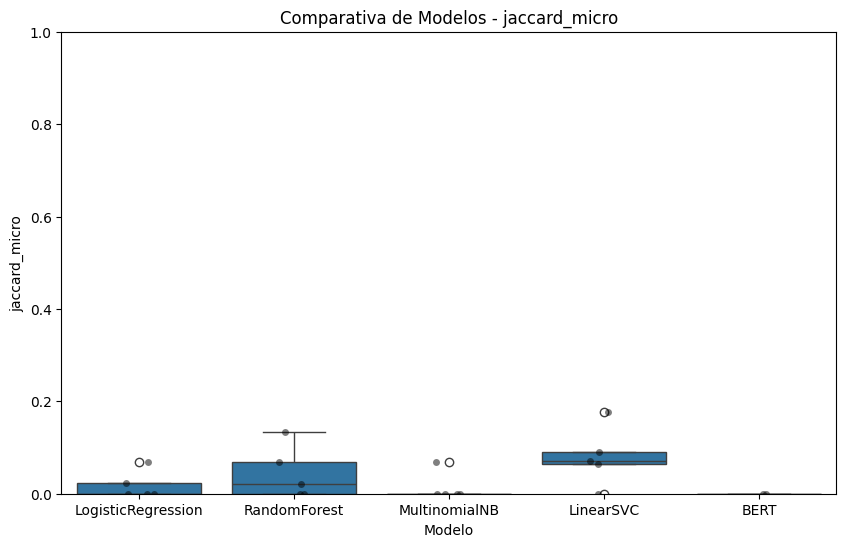

In [9]:
# ------------------------------------------
# ----------------- Modelos  ---------------
# ------------------------------------------

# Binarización de etiquetas
mlb: MultiLabelBinarizer = MultiLabelBinarizer() # Creamos un objeto MultiLabelBinarizer para convertir las etiquetas en formato binario
y: np.ndarray = mlb.fit_transform(df["habilidades"]) # Transformamos las habilidades en formato binario
X: pd.Series = df["texto"].fillna("") # Obtenemos el texto de las tareas y llenamos los valores nulos con una cadena vacía

# Modelos a evaluar
modelos: dict[str, Any] = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(),
    "MultinomialNB": MultinomialNB(),
    "LinearSVC": LinearSVC(),
}

# Validación cruzada estratificada multilabel
skf: MultilabelStratifiedKFold = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)
resultados: dict[str, dict[str, list[float]]] = {}

metricas: list[str] = [
    "precision_micro",
    "recall_micro",
    "hamming_loss",
    "jaccard_micro",
]
resultados = {modelo: {m: [] for m in metricas} for modelo in modelos} 
resultados["BERT"] = {m: [] for m in metricas}  

# ----- Modelos clásicos -----
for nombre, base_modelo in modelos.items(): # recorremos los modelos a evaluar
    print(f"Entrenando modelo: {nombre}") 
    pipeline: Pipeline = make_pipeline(TfidfVectorizer(), OneVsRestClassifier(base_modelo)) # Creamos un pipeline que incluye un vectorizador TF-IDF y el modelo base

    for train_idx, test_idx in skf.split(X, y): # Realizamos la validación cruzada estratificada

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx] # Obtenemos los conjuntos de entrenamiento y prueba
        y_train, y_test = y[train_idx], y[test_idx] # Obtenemos las etiquetas correspondientes a los conjuntos de entrenamiento y prueba

        pipeline.fit(X_train, y_train) # Entrenamos el pipeline con los datos de entrenamiento
        y_pred: np.ndarray = pipeline.predict(X_test) # Realizamos las predicciones sobre el conjunto de prueba


        resultados[nombre]["precision_micro"].append(
            precision_score(y_test, y_pred, average="micro", zero_division=0)
        ) # Calculamos la precisión micro y la agregamos a los resultados
        
        resultados[nombre]["recall_micro"].append(
            recall_score(y_test, y_pred, average="micro")
        ) # Calculamos la recuperación micro y la agregamos a los resultados
        
        resultados[nombre]["hamming_loss"].append(hamming_loss(y_test, y_pred)) # Calculamos la pérdida de Hamming y la agregamos a los resultados
        resultados[nombre]["jaccard_micro"].append(
            jaccard_score(y_test, y_pred, average="micro")
        ) # Calculamos el índice de Jaccard micro y lo agregamos a los resultados


# ----- BERT con validación cruzada -----

print("Entrenando modelo: BERT (con cross-validation)")

tokenizer: BertTokenizer = BertTokenizer.from_pretrained("./modelos/") # Cargamos el tokenizador BERT desde el directorio local

# Validación cruzada con BERT
skf_bert = MultilabelStratifiedKFold(n_splits=2, shuffle=True, random_state=42)
bert_scores = [] 

for fold, (train_idx, test_idx) in enumerate(skf_bert.split(X, y)): # Iteramos sobre los índices de entrenamiento y prueba generados por la validación cruzada estratificada

    X_train, X_test = X.iloc[train_idx].tolist(), X.iloc[test_idx].tolist() # Obtenemos los textos de entrenamiento y prueba
    y_train, y_test = y[train_idx], y[test_idx] # Obtenemos las etiquetas correspondientes a los textos de entrenamiento y prueba

    train_dataset = TareaDataset(X_train, y_train, tokenizer) # Creamos el dataset de entrenamiento
    test_dataset = TareaDataset(X_test, y_test, tokenizer) # Creamos el dataset de prueba

    model = BertForSequenceClassification.from_pretrained(
        "./modelos/",
        num_labels=y.shape[1],
        problem_type="multi_label_classification",
    ) # Cargamos el modelo BERT desde el directorio local, especificando el número de etiquetas y el tipo de problema

    training_args = TrainingArguments(
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        num_train_epochs=3,
        eval_strategy="no",
        save_strategy="no",
        logging_steps=10,
        disable_tqdm=True,
        report_to="none",
        log_level="error",
    ) # Configuramos los argumentos de entrenamiento para el modelo BERT

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        tokenizer=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer),
    ) # Creamos el objeto Trainer para manejar el entrenamiento y evaluación del modelo BERT
    
    trainer.train() # Entrenamos el modelo BERT

    preds = trainer.predict(test_dataset).predictions # Realizamos las predicciones sobre el conjunto de prueba
    preds_bin = (torch.sigmoid(torch.tensor(preds)) > 0.5).int().numpy() # Convertimos las predicciones a formato binario usando un umbral de 0.5

    resultados["BERT"]["precision_micro"].append(
        precision_score(y_test, preds_bin, average="micro", zero_division=0)
    ) # Calculamos la precisión micro y la agregamos a los resultados
    
    resultados["BERT"]["recall_micro"].append(
        recall_score(y_test, preds_bin, average="micro")
    ) # Calculamos la recuperación micro y la agregamos a los resultados
    
    resultados["BERT"]["hamming_loss"].append(hamming_loss(y_test, preds_bin)) # Calculamos la pérdida de Hamming y la agregamos a los resultados
    
    resultados["BERT"]["jaccard_micro"].append(
        jaccard_score(y_test, preds_bin, average="micro")
    ) # Calculamos el índice de Jaccard micro y lo agregamos a los resultados


for m in metricas: # Recorremos las métricas para graficar los resultados
    df_plot: pd.DataFrame = pd.DataFrame(
        [
            {"Modelo": modelo, m: valor}
            for modelo, scores in resultados.items()
            for valor in scores[m]
        ]
    )

    plt.figure(figsize=(10, 6))
    sns.boxplot(x="Modelo", y=m, data=df_plot)
    sns.stripplot(x="Modelo", y=m, data=df_plot, color="black", alpha=0.5, jitter=True)
    plt.title(f"Comparativa de Modelos - {m}")
    plt.ylim(0, 1)
    plt.show()